In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th
from scipy.stats import pearsonr

In [2]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return np.array(result.tolist())

In [3]:
phantom_data=scipy.io.loadmat('scanner data/Scanner_3TSKYRA_MGH.mat')

In [4]:
phantom_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jan 20 18:00:15 2021',
 '__version__': '1.0',
 '__globals__': [],
 'ground_truth': array([[835.10879388, 833.41897485, 838.34265833, ..., 838.34265833,
         831.56272655, 830.18548258],
        [871.49606089, 871.06793053, 871.73861031, ..., 871.73861031,
         870.09203112, 865.47466757],
        [838.8405145 , 840.5165299 , 836.17924523, ..., 836.17924523,
         842.99758531, 850.00119903],
        ...,
        [624.6058596 , 624.14669585, 625.30848448, ..., 624.14669585,
         625.13948893, 625.23347262],
        [599.50890386, 608.91649371, 601.76517965, ..., 608.91649371,
         604.87498696, 601.14759216],
        [627.01134719, 630.19822656, 627.11642156, ..., 630.19822656,
         628.47521382, 626.9509015 ]]),
 'measured': array([[832.22790889, 822.23189274, 851.23588628, ..., 786.33146446,
         796.34123757, 798.35102037],
        [876.29231968, 882.26262559, 883.23299181, ..., 861.29604

In [5]:
phantom_data_sd=scipy.io.loadmat('scanner data/Scanner_3TSKYRA_MGH_SDs.mat')
phantom_data_sd

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Jan 20 18:02:24 2021',
 '__version__': '1.0',
 '__globals__': [],
 'std_dev': array([[ 9.53827998,  9.13947383, 10.13846973, ...,  7.60601995,
          9.07057942,  8.87610252]])}

In [7]:
gt = phantom_data["ground_truth"]
fmri = phantom_data["measured"]
static_std = phantom_data_sd['std_dev'][0]
print(gt.shape,fmri.shape,static_std.shape)

(2432, 600) (2432, 600) (2432,)


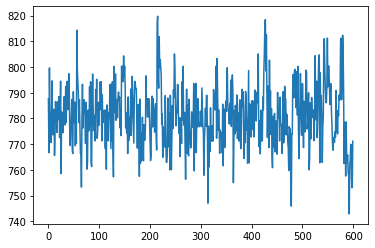

In [38]:
plt.plot(fmri[800])

In [8]:
#split up the sessions.  For Skyra the sessions are 861,859 and 712 voxels
s1,s2,s3 = 861,859,712
gt1 = gt[:s1]
gt2 = gt[s1:s1+s2]
gt3 = gt[s1+s2:]
fmri1 = fmri[:s1]
fmri2 = fmri[s1:s1+s2]
fmri3 = fmri[s1+s2:]
static_std1 = static_std[:s1]
static_std2 = static_std[s1:s1+s2]
static_std3 = static_std[s1+s2:]

#just checking the length
print(gt1.shape,gt2.shape,gt3.shape)

(861, 600) (859, 600) (712, 600)


792.436871844282 832.7056014381707 644.8627239619256
(2432, 600) (2432, 600) (2432,)


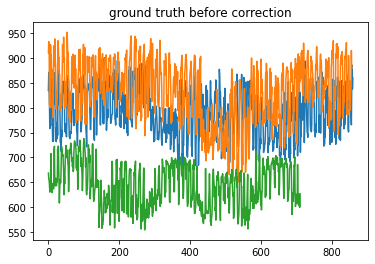

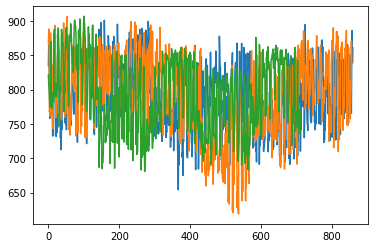

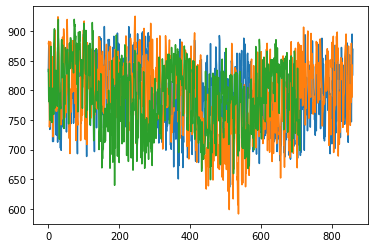

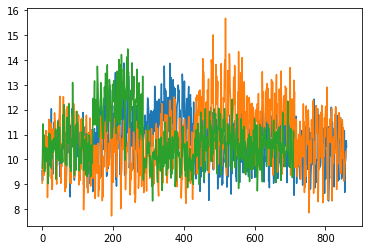

In [9]:
# lets correct for different amplification for the three sessions
plt.figure()
plt.plot(gt1.T[0])
plt.plot(gt2.T[0])
plt.plot(gt3.T[0])
plt.title("ground truth before correction")
print(gt1.T[0].mean(),gt2.T[0].mean(),gt3.T[0].mean())
#lets get them all to the same level
gt1_norm = gt1
gt2_norm = gt2*gt1.T[0].mean()/gt2.T[0].mean()
gt3_norm = gt3*gt1.T[0].mean()/gt3.T[0].mean()

plt.figure()
plt.plot(gt1_norm.T[0])
plt.plot(gt2_norm.T[0])
plt.plot(gt3_norm.T[0])

# now correct the fmri signal
fmri1_norm = fmri1
fmri2_norm = fmri2*gt1.T[0].mean()/gt2.T[0].mean()
fmri3_norm = fmri3*gt1.T[0].mean()/gt3.T[0].mean()

plt.figure()
plt.plot(fmri1_norm.T[0])
plt.plot(fmri2_norm.T[0])
plt.plot(fmri3_norm.T[0])

static_std1_norm = static_std1
static_std2_norm = static_std2*gt1.T[0].mean()/gt2.T[0].mean()
static_std3_norm = static_std3*gt1.T[0].mean()/gt3.T[0].mean()

plt.figure()
plt.plot(static_std1_norm.T)
plt.plot(static_std2_norm.T)
plt.plot(static_std3_norm.T)

# lets put everything together
gt_norm = np.vstack((gt1_norm,gt2_norm,gt3_norm))
fmri_norm = np.vstack((fmri1_norm,fmri2_norm,fmri3_norm))
static_std_norm = np.concatenate((static_std1_norm,static_std2_norm,static_std3_norm))
print(gt_norm.shape,fmri_norm.shape,static_std_norm.shape)

In [10]:
# lets see how the standard deviations compare
gt_std = np.std(gt_norm,axis=1)
fmri_std = np.std(fmri_norm,axis=1)
print(fmri_std.shape,gt_std.shape)
noise_std = np.std((fmri_norm-gt_norm),axis=1)
print (noise_std.mean(),fmri_std.mean(),gt_std.mean(),static_std_norm.mean())
print(np.sqrt(gt_std.mean()**2+static_std.mean()**2))
print("Scanner instability percent:",(noise_std.mean()**2-static_std.mean()**2)/static_std.mean()**2)

(2432,) (2432,)
13.121563810193763 13.604067683591133 5.959447853894609 10.818025423884134
12.006978484806586
Scanner instability percent: 0.5846429235950024


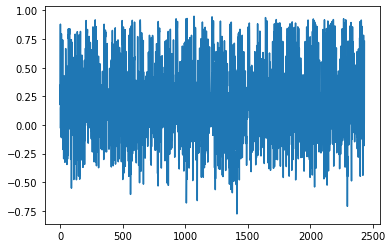

In [11]:
fmri_gt_pearsonr = [pearsonr(f,g)[0] for f,g in zip(fmri_norm,gt_norm)]
fmri_gt_pearsonr = np.array(fmri_gt_pearsonr)
plt.plot(fmri_gt_pearsonr)

(array([  5.,  44., 135., 296., 507., 500., 350., 224., 203., 168.]),
 array([-0.77740569, -0.60472235, -0.43203902, -0.25935569, -0.08667236,
         0.08601098,  0.25869431,  0.43137764,  0.60406097,  0.7767443 ,
         0.94942764]),
 <BarContainer object of 10 artists>)

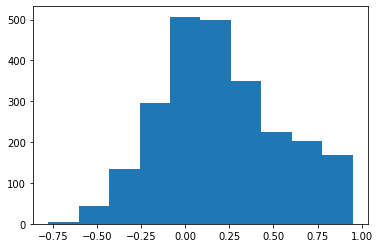

In [12]:
plt.hist(fmri_gt_pearsonr)

(array([  7.,  10.,  16.,  32.,  57.,  72., 116., 139., 141., 191., 196.,
        218., 186., 200., 185., 148., 149.,  83.,  93.,  59.,  54.,  34.,
         16.,  12.,  11.,   4.,   2.,   0.,   0.,   1.]),
 array([-31.26936674, -28.41316108, -25.55695541, -22.70074975,
        -19.84454408, -16.98833842, -14.13213275, -11.27592709,
         -8.41972142,  -5.56351576,  -2.7073101 ,   0.14889557,
          3.00510123,   5.8613069 ,   8.71751256,  11.57371823,
         14.42992389,  17.28612956,  20.14233522,  22.99854088,
         25.85474655,  28.71095221,  31.56715788,  34.42336354,
         37.27956921,  40.13577487,  42.99198054,  45.8481862 ,
         48.70439187,  51.56059753,  54.41680319]),
 <BarContainer object of 30 artists>)

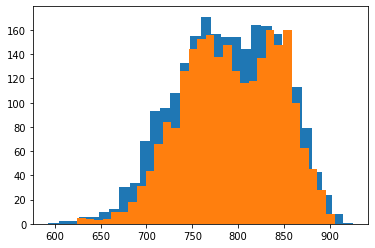

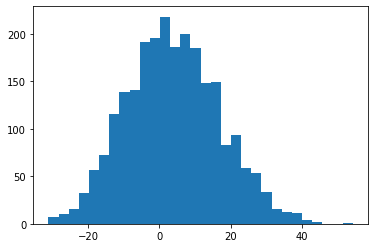

In [13]:
gt_mean = np.mean(gt_norm,axis=1)
fmri_mean = np.mean(fmri_norm,axis=1)
gt_std = np.std(gt_norm,axis=1)
fmri_std = np.std(fmri_norm,axis=1)
fmri_minus_gt = gt_mean-fmri_mean
plt.figure()
plt.hist(fmri_mean,bins=30)
plt.hist(gt_mean,bins=30)
plt.figure()
plt.hist(fmri_minus_gt,bins=30)

In [14]:
gt_skew = sp.stats.skew(gt_norm,axis=1)
fmri_skew = sp.stats.skew(fmri_norm,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

skew_idx = np.argsort(gt_nooutliers)

2 21


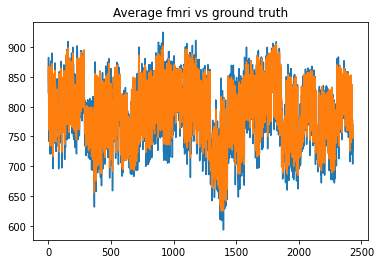

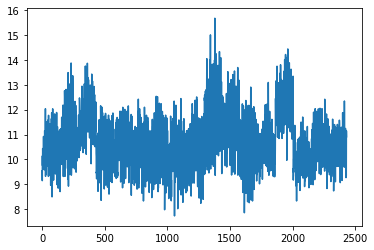

In [76]:
# lets see whether the thermal noise is independent of the intensity level
plt.figure()
plt.plot(fmri_mean)
plt.plot(gt_mean)
plt.title("Average fmri vs ground truth")

plt.figure()
plt.plot(static_std_norm)


In [15]:
# for some analysis we would like to analyze with mean zero
gt_norm_MZ = (gt_norm - gt_mean[:,np.newaxis])
fmri_norm_MZ = (fmri_norm - fmri_mean[:,np.newaxis])
print(gt_norm_MZ.shape)

(2432, 600)


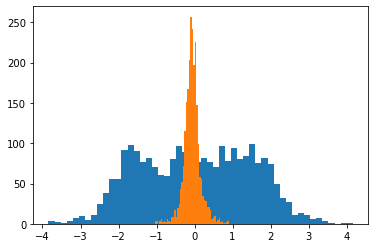

In [79]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

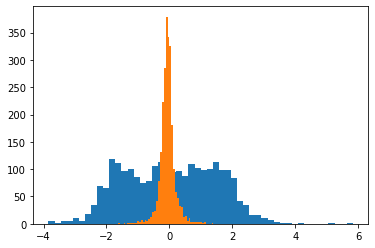

In [80]:
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

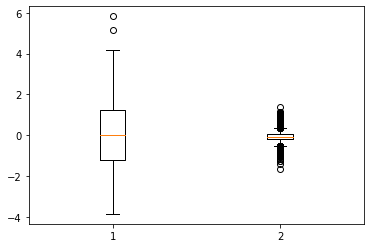

In [81]:
_ = plt.boxplot([gt_skew,fmri_skew])

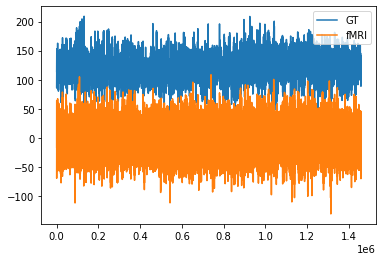

In [16]:
idx = 800
gt_data = gt_norm_MZ[skew_idx].flatten()
fmri_data = fmri_norm_MZ[skew_idx].flatten()
plt.plot(gt_data+120,label="GT")
plt.plot(fmri_data,label="fMRI")
plt.legend(loc="upper right")

In [17]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_2 = pm.sample()

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 692 seconds.


In [ ]:
#pm.traceplot(posterior_2)

In [87]:
with pm.Model() as multi_noise:
    pm.summary(posterior_2)

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma1,12.309,0.009,12.293,12.325,0.0,0.0,2813.0,2813.0,2816.0,2482.0,1.0
ampl_noise,0.706,0.003,0.701,0.711,0.0,0.0,2645.0,2643.0,2646.0,2021.0,1.0


In [18]:
# now we want to see what are the contributions to the noise
# here we assume that the multiplicative noise is prop to delta_S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)

sigma mult: 5.319290433622847
sigma thermal: 12.309295287914912
sigma thermal normalized 1.634711754807941
sigma thermal normalized error 0.001152083349605168
sigma total noise fitted: 13.409459392619667
sigma total (fmri-gt): 13.321727587682403
sigma GT: 7.529948476672639
signal to noise ratio: 0.3153272259841397
sigma multi/total: 0.1573565655102798


In [19]:
# same analysis for multiplicative noise prop to S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*(gt_mean**2))/len(gt_mean))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("sigma fmri:",np.std(fmri_data))
print("sigma fmri/sigma GT:",np.std(fmri_data)/np.std(gt_data))
print("signal to noise ratio:",np.std(gt_mean)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)
print("sigma multi/thermal:",sigma_mult**2/sig**2)

sigma mult: 561.1495928667431
sigma thermal: 12.309295287914912
sigma thermal normalized 1.634711754807941
sigma thermal normalized error 0.001152083349605168
sigma total noise fitted: 561.2845840792321
sigma total (fmri-gt): 13.321727587682403
sigma GT: 7.529948476672639
sigma fmri: 14.075899575172947
sigma fmri/sigma GT: 1.8693221631966406
signal to noise ratio: 0.008592387958819262
sigma multi/total: 0.999519049753543
sigma multi/thermal: 2078.2171484809705


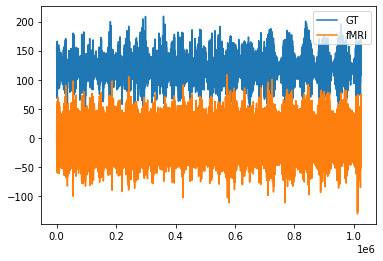

In [20]:
# lets see whether anything changes if we only take pearson positive traces
idx = 800
gt_data = gt_norm_MZ[fmri_gt_pearsonr>0].flatten()
fmri_data = fmri_norm_MZ[fmri_gt_pearsonr>0].flatten()
plt.plot(gt_data+120,label="GT")
plt.plot(fmri_data,label="fMRI")
plt.legend(loc="upper right")

In [21]:
# here we assume that the two distributions add
with pm.Model() as multi_noise2:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl_noise = pm.Uniform('ampl_noise',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl_noise**2*gt_data**2), observed=fmri_data)

    posterior_3 = pm.sample()

/opt/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ampl_noise, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 494 seconds.


In [22]:
# now we want to see what are the contributions to the noise
# here we assume that the multiplicative noise is prop to delta_S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*gt_data**2)/len(gt_data))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("signal to noise ratio:",np.std(gt_data)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)

sigma mult: 5.789025513689241
sigma thermal: 12.309295287914912
sigma thermal normalized 1.5020674167903623
sigma thermal normalized error 0.0010586006100335018
sigma total noise fitted: 13.602630880944657
sigma total (fmri-gt): 12.841471474892998
sigma GT: 8.194902006607386
signal to noise ratio: 0.3629457396330606
sigma multi/total: 0.18111945417018727


In [23]:
# same analysis for multiplicative noise prop to S
sig = np.mean(posterior_2['sigma1'])
amp_noise = np.mean(posterior_2['ampl_noise'])
sigma_mult = np.sqrt(np.sum((amp_noise**2)*(gt_mean**2))/len(gt_mean))
sig_total = np.sqrt(sigma_mult**2+sig**2)
print("sigma mult:",sigma_mult)
print("sigma thermal:",sig)
print("sigma thermal normalized",sig/np.std(gt_data))
print("sigma thermal normalized error",np.std(posterior_2['sigma1'])/np.std(gt_data))
print("sigma total noise fitted:",np.sqrt(sigma_mult**2+sig**2))
print("sigma total (fmri-gt):",np.std(fmri_data-gt_data))
print("sigma GT:",np.std(gt_data))
print("sigma fmri:",np.std(fmri_data))
print("sigma fmri/sigma GT:",np.std(fmri_data)/np.std(gt_data))
print("signal to noise ratio:",np.std(gt_mean)**2/(sigma_mult**2+sig**2))
print("sigma multi/total:",sigma_mult**2/sig_total**2)
print("sigma multi/thermal:",sigma_mult**2/sig**2)

sigma mult: 561.1495928667431
sigma thermal: 12.309295287914912
sigma thermal normalized 1.5020674167903623
sigma thermal normalized error 0.0010586006100335018
sigma total noise fitted: 561.2845840792321
sigma total (fmri-gt): 12.841471474892998
sigma GT: 8.194902006607386
sigma fmri: 14.738122270047977
sigma fmri/sigma GT: 1.798450092284804
signal to noise ratio: 0.008592387958819262
sigma multi/total: 0.999519049753543
sigma multi/thermal: 2078.2171484809705


In [97]:
with pm.Model() as multi_noise2:
    display(pm.summary(posterior_3))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma1,12.111,0.010,12.093,12.130,0.0,0.0,2802.0,2802.0,2818.0,2409.0,1.0
ampl_noise,0.533,0.003,0.528,0.539,0.0,0.0,2873.0,2873.0,2902.0,2428.0,1.0
